# Import libraries & Training data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
train = pd.read_csv('./datasets/train.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# EDA

In [3]:
def basic_eda (df):
    print('Shape:') 
    print(df.shape)
    print('------------------------------------------')
    print('Column Info:')
    print(df.info())
    print('------------------------------------------')
    print('Null Values per Column')
    print(df.isnull().sum())
    print('------------------------------------------')
    print('Describe:')
    print(df.describe().T)
    for i in df:
        print('------------------------------------------')
        print('Values per Column:')
        print(i)
        print(df[i].value_counts())

In [4]:
basic_eda(train)

Shape:
(2051, 81)
------------------------------------------
Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 n

0       1075
100       53
144       46
192       43
120       40
168       36
140       23
224       17
160       14
143       13
240       12
216       12
200       10
264        8
280        8
208        8
108        8
156        8
48         8
132        7
196        7
112        7
136        7
128        7
210        7
188        7
252        7
182        6
203        6
158        6
        ... 
153        1
131        1
129        1
123        1
121        1
119        1
115        1
103        1
99         1
97         1
87         1
75         1
73         1
51         1
536        1
45         1
35         1
33         1
1424       1
870        1
736        1
728        1
684        1
668        1
646        1
586        1
576        1
550        1
546        1
394        1
Name: Wood Deck SF, Length: 322, dtype: int64
------------------------------------------
Values per Column:
Open Porch SF
0      912
48      40
36      38
40      34
32      29
20      24
24      23
60      

# Munging & Feature Engineering

In [5]:
# Dropping row 1699 since Garage Yr Blt is literally in the future (2207) 
# Also dropping 960 and 1885 as these are two extreme outliers in Overall QualxTotal SF as discovered later on

train.drop([1699, 960, 1885, 1409], inplace=True)

In [6]:
# Get dummies for all categorical variables

train_dummies = pd.get_dummies(train, columns=[string_cols for string_cols in train if train[string_cols].dtype == object])

In [7]:
# Determined correlation for each categorical value per variable as compared to SalePrice
# Correlations were saved in separate file 'Categorical Vars.ipynb' for easy look up

# NEIGHBORHOODS
# hoods = ['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_Blmngtn', 
#          'Neighborhood_ClearCr',
#          'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
#          'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 
#          'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
#          'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
#          'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 
#          'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']

# for i in hoods:
#     print(i, np.corrcoef(train_dummies[i], train_dummies['SalePrice'])[0][1])

In [8]:
# The following are functions to create bins for above correlation per categorical values

def qual_types(x):
    if x == 'Ex':
        return 5
    elif x == 'Gd':
        return 4
    elif x == 'TA':
        return 3
    elif x == 'Fa':
        return 2
    elif x == 'Po':
        return 1
    else:
        None
        
def score_hoods(x):    
    excellent = ['NridgHt']
    good = ['CollgCr', 'NoRidge', 'Somerst', 'StoneBr', 'Timber', 'NAmes']
    okay = ['ClearCr', 'Crawfor', 'Gilbert', 'Greens', 'GrnHill', 'NWAmes', 'SawyerW', 'Veenker', 'BrDale',
            'Blmngtn']
    bad = ['Blueste', 'Landmrk', 'Mitchel', 'NPkVill', 'SWISU', 'OldTown', 'Edwards', 'Sawyer', 'BrkSide',
           'IDOTRR', 'MeadowV']
    
    if x in good:
        return 3
    elif x in excellent:
        return 4
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_zones(x):    
    good = ['RL', 'FV']
    okay = ['RH', 'A (agr)', 'I (all)']
    bad = ['RM', 'C (all)']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_lot_shapes(x):
    good = ['IR1']
    okay = ['IR2', 'IR3']
    bad = ['Reg']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_land_contours(x):
    good = ['HLS']
    okay = ['Low']
    bad = ['Lvl', 'Bnk']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_house_styles(x):
    good = ['2Story']
    okay = ['1Story', 'SLvl', 'SFoyer', '2.5Unf', '1.5Unf', '2.5Fin']
    bad = ['1.5Fin']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_roof_styles(x):
    good = ['Hip']
    okay = ['Flat', 'Gambrel', 'Mansard', 'Shed']
    bad = ['Gable']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_exteriors(x):
    good = ['VinylSd', 'CemntBd', 'CmentBd']
    okay = ['Plywood', 'BrkFace', 'WdShing', 'Stucco', 'BrkComm', 'CBlock', 'Stone', 'ImStucc', 'AsphShn',
            'Wd Shng', 'Brk Cmn']
    bad = ['MetalSd', 'HdBoard', 'Wd Sdng', 'AsbShng']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_mas_vnrs(x):
    good = ['Stone', 'BrkFace']
    okay = ['BrkCmn']
    bad = ['None']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_foundations(x):
    good = ['PConc']
    okay = ['Stone', 'Wood']
    bad = ['CBlock', 'BrkTil', 'Slab']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_bsmt_exposures(x):
    good = ['Av', 'Gd']
    okay = ['Mn']
    bad = ['No']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_bsmt_finish(x):
    good = ['GLQ']
    okay = ['ALQ', 'LwQ']
    bad = ['Unf', 'BLQ', 'Rec']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_yes_nos(x):
    good = ['Y']
    okay = ['P']
    bad = ['N']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_electrical(x):
    good = ['SBrkr']
    okay = ['FuseP', 'Mix']
    bad = ['FuseA', 'FuseF']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_garage_types(x):
    good = ['Attchd', 'BuiltIn']
    okay = ['Basment', '2Types', 'CarPort']
    bad = ['Detchd']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0
    
def score_garage_finishes(x):
    good = ['Fin']
    okay = ['RFn']
    bad = ['Unf']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0

def score_gpaved(x):
    good = ['Fin']
    okay = ['RFn']
    bad = ['Unf']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0

def score_sale_types(x):
    good = ['New']
    okay = ['ConLD', 'CWD', 'ConLI', 'ConLw', 'Con', 'Oth']
    bad = ['WD ', 'COD']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0

def score_exteriors_qual(x):
    good = ['Ex','Gd']
    okay = ['Fa']
    bad = ['TA']
    
    if x in good:
        return 3
    elif x in okay:
        return 2
    elif x in bad:
        return 1
    else:
        return 0

In [9]:
# Encoded variables where values are strings using functions defined above

train['Neighborhood_Qual'] = train['Neighborhood'].map(score_hoods)
train['MS Zoning_Qual'] = train['MS Zoning'].map(score_zones)
train['Lot Shapes_adj'] = train['Lot Shape'].map(score_lot_shapes)
train['Land Contours_adj'] = train['Land Contour'].map(score_land_contours)
train['House Styles_adj'] = train['House Style'].map(score_house_styles)
train['Roof Styles_adj'] = train['Roof Style'].map(score_roof_styles)
train['Exterior 1sts_adj'] = train['Exterior 1st'].map(score_exteriors)
train['Exterior 2nds_adj'] = train['Exterior 2nd'].map(score_exteriors)
train['Mas Vnr Types_adj'] = train['Mas Vnr Type'].map(score_mas_vnrs)
train['Heating QC_adj'] = train['Heating QC'].map(qual_types)
train['Kitchen Quals_adj'] = train['Kitchen Qual'].map(qual_types)
train['Foundations_adj'] = train['Foundation'].map(score_foundations)
train['Bsmt Exposures_adj'] = train['Bsmt Exposure'].map(score_bsmt_exposures)
train['Bsmt Finishes_adj'] = train['BsmtFin Type 1'].map(score_bsmt_finish)
train['Central Airs_adj'] = train['Central Air'].map(score_yes_nos)
train['Electrical_adj'] = train['Electrical'].map(score_electrical)
train['Garage Types_adj'] = train['Garage Type'].map(score_garage_types)
train['Garage Finishes_adj'] = train['Garage Finish'].map(score_garage_finishes)
train['Paved Drives_adj'] = train['Paved Drive'].map(score_yes_nos)
train['Sales Types_adj'] = train['Sale Type'].map(score_sale_types)

In [10]:
# Tested that none were left zero / incorrectly binned

# train['Exterior 1sts_adj'].value_counts()

In [11]:
# Adding interactions based on above & also polynomial lasso info from later

train['Total SF'] = train['Gr Liv Area'] + train['Total Bsmt SF'] + train['Garage Area']
train['Overall QualxTotal SF'] = train['Overall Qual'] * train['Total SF']
train['Year BuiltxYear Remod/Add'] = train['Year Built'] * train['Year Remod/Add']
train['Total Baths'] = train['Bsmt Full Bath'] + train['Bsmt Half Bath'] + train['Full Bath'] + train['Half Bath']
train['Fireplaces_Baths_Cars'] = train['Fireplaces'] + train['Total Baths'] + train['Garage Cars']
train['Neighborhood_QualxMS Zoning_Qual'] = train['Neighborhood_Qual'] * train['MS Zoning_Qual']
train['Mas Vnr_adj'] = train['Mas Vnr Area'] + train['Mas Vnr Types_adj']
train['Exteriors Total'] = train['Exterior 1sts_adj'] + train['Exterior 2nds_adj']
train['Bsmt ExposuresxFinishes'] = train['Bsmt Exposures_adj'] * train['Bsmt Finishes_adj']
train['Garage TypesxFinishes'] = train['Garage Types_adj'] * train['Garage Finishes_adj']
train['HousexExteriorsxRoof'] = train['House Styles_adj'] * train['Exteriors Total'] * train['Roof Styles_adj']
train['Mas VnrxFoundation'] = train['Mas Vnr_adj'] * train['Foundations_adj']

In [12]:
# Dropped nan values

train.dropna(subset=['Overall QualxTotal SF', 'Fireplaces_Baths_Cars', 'Mas Vnr_adj'],
             inplace=True)

**Defining Features**

In [13]:
X = train[['Overall QualxTotal SF', 
           'Year BuiltxYear Remod/Add', 
           'Neighborhood_Qual',
           'Fireplaces_Baths_Cars', 
           'Garage TypesxFinishes',
           'Mas VnrxFoundation',
           'HousexExteriorsxRoof',
           'Foundations_adj',
           'Bsmt ExposuresxFinishes',
           'Paved Drives_adj', 
           'Lot Shapes_adj', 
           'Electrical_adj',
           'Land Contours_adj', 
           'Roof Styles_adj', 
           'Central Airs_adj',           
           'Sales Types_adj',
           'MS Zoning_Qual',
#            'SalePrice'
          ]]

# Note that 'SalePrice' is excluded from list above; it was included when running correlations and pairplots below

y = train['SalePrice']

In [14]:
# Checking if any null values present, if so, dropped them above

# X.isnull().sum()

In [15]:
# Checking for correlations between variables

# X.corr()['SalePrice']

In [16]:
# Plotted above to see if any outliers existed and if there were any obvious trends with SalePrice

# sns.pairplot(X);
# plt.scatter(x=train['Mas VnrxHousexExteriorsxRoof'], y=train['SalePrice'])

# Modeling

**Transformation: ** Train-Test-Split, Polynomials, Standardization

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

# poly = PolynomialFeatures(include_bias=False)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Linear Regression Score: ", lr.score(X_train, y_train))
print("Cross Val Scores: ", cross_val_score(lr, X_train, y_train, cv=3))

Linear Regression Score:  0.8926655604497614
Cross Val Scores:  [0.89619579 0.89064267 0.88480266]


**Plotting Values vs. Predictions**

Linear Test Score: 0.8977498610462774


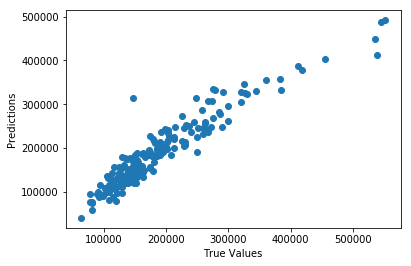

In [19]:
# Visualized how closely predictions were falling to actual values

model = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Linear Test Score:", model.score(X_test, y_test))

**Ridge, Lasso, ElasticNet**

In [20]:
# Ridge
r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_model = ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Lasso
l_alphas = np.arange(0.0001, 0.015, 0.0025)
lasso_model = LassoCV(alphas=l_alphas, cv=5)
lasso_model = lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)

# ElasticNet
e_alphas = np.arange(0.5, 1.0, 0.005)
e_ratio = 0.5
e_model = ElasticNetCV(alphas=e_alphas, l1_ratio=e_ratio, cv=5)
e_model = e_model.fit(X_train, y_train)
e_predictions = e_model.predict(X_test)

**Scoring R, L, EN**

In [21]:
# Checked to see which model was generally showing greatest improvement

print("Ridge train score: ", ridge_model.score(X_train, y_train))
print("Ridge test score: ", ridge_model.score(X_test, y_test))
print()
print("Lasso train score: ", lasso_model.score(X_train, y_train))
print("Lasso test score: ", lasso_model.score(X_test, y_test))
print()
print("ElasticNet train score: ", e_model.score(X_train, y_train))
print("ElasticNet test score: ", e_model.score(X_test, y_test))

Ridge train score:  0.8926637394000886
Ridge test score:  0.8977790947926146

Lasso train score:  0.8926655604493627
Lasso test score:  0.8977498452421873

ElasticNet train score:  0.8703902139880639
ElasticNet test score:  0.8777313255661927


In [22]:
# Looked at output of lasso coefficients to see if any variables had a greater pull than others

# lasso_coefs_list = list(zip(abs(lasso_model.coef_), model.get_feature_names(X.columns)))
# lasso_coefs_list

**Plotting R, L, EN**

Lin R2 Score: 0.8977498610462774
Ridge R2 Score: 0.8977790947926146
Lasso R2 Score: 0.8977498452421873
E-Net R2 Score: 0.8777313255661927


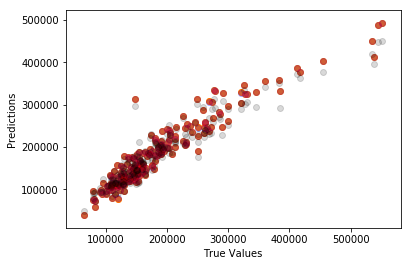

In [23]:
# Visualized how Ridge, Lasso, and ElasticNet were performing

plt.scatter(y_test, predictions, color='orange', alpha=0.95)
plt.scatter(y_test, ridge_predictions, color='blue', alpha=0.25)
plt.scatter(y_test, lasso_predictions, color='red', alpha=0.25)
plt.scatter(y_test, e_predictions, color='black', alpha=0.15)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Lin R2 Score:", model.score(X_test, y_test))
print("Ridge R2 Score:", ridge_model.score(X_test, y_test))
print("Lasso R2 Score:", lasso_model.score(X_test, y_test))
print("E-Net R2 Score:", e_model.score(X_test, y_test))


# Applying Model to Test Data

In [24]:
test_data = pd.read_csv('./datasets/test.csv')

In [25]:
test_data['Neighborhood_Qual'] = test_data['Neighborhood'].map(score_hoods)
test_data['MS Zoning_Qual'] = test_data['MS Zoning'].map(score_zones)
test_data['Lot Shapes_adj'] = test_data['Lot Shape'].map(score_lot_shapes)
test_data['Land Contours_adj'] = test_data['Land Contour'].map(score_land_contours)
test_data['House Styles_adj'] = test_data['House Style'].map(score_house_styles)
test_data['Roof Styles_adj'] = test_data['Roof Style'].map(score_roof_styles)
test_data['Exterior 1sts_adj'] = test_data['Exterior 1st'].map(score_exteriors)
test_data['Exterior 2nds_adj'] = test_data['Exterior 2nd'].map(score_exteriors)
test_data['Mas Vnr Types_adj'] = test_data['Mas Vnr Type'].map(score_mas_vnrs)
test_data['Heating QC_adj'] = test_data['Heating QC'].map(qual_types)
test_data['Kitchen Quals_adj'] = test_data['Kitchen Qual'].map(qual_types)
test_data['Foundations_adj'] = test_data['Foundation'].map(score_foundations)
test_data['Bsmt Exposures_adj'] = test_data['Bsmt Exposure'].map(score_bsmt_exposures)
test_data['Bsmt Finishes_adj'] = test_data['BsmtFin Type 1'].map(score_bsmt_finish)
test_data['Central Airs_adj'] = test_data['Central Air'].map(score_yes_nos)
test_data['Electrical_adj'] = test_data['Electrical'].map(score_electrical)
test_data['Garage Types_adj'] = test_data['Garage Type'].map(score_garage_types)
test_data['Garage Finishes_adj'] = test_data['Garage Finish'].map(score_garage_finishes)
test_data['Paved Drives_adj'] = test_data['Paved Drive'].map(score_yes_nos)
test_data['Sales Types_adj'] = test_data['Sale Type'].map(score_sale_types)

test_data['Total SF'] = test_data['Gr Liv Area'] + test_data['Total Bsmt SF'] + test_data['Garage Area']
test_data['Overall QualxTotal SF'] = test_data['Overall Qual'] * test_data['Total SF']
test_data['Year BuiltxYear Remod/Add'] = test_data['Year Built'] * test_data['Year Remod/Add']
test_data['Total Baths'] = test_data['Bsmt Full Bath'] + test_data['Bsmt Half Bath'] + \
test_data['Full Bath'] + test_data['Half Bath']
test_data['Fireplaces_Baths_Cars'] = test_data['Fireplaces'] + test_data['Total Baths'] + test_data['Garage Cars']
test_data['Neighborhood_QualxMS Zoning_Qual'] = test_data['Neighborhood_Qual'] * test_data['MS Zoning_Qual']
test_data['Mas Vnr_adj'] = test_data['Mas Vnr Area'] + test_data['Mas Vnr Types_adj']
test_data['Exteriors Total'] = test_data['Exterior 1sts_adj'] + test_data['Exterior 2nds_adj']
test_data['Bsmt ExposuresxFinishes'] = test_data['Bsmt Exposures_adj'] * test_data['Bsmt Finishes_adj']
test_data['Garage TypesxFinishes'] = test_data['Garage Types_adj'] * test_data['Garage Finishes_adj']
test_data['HousexExteriorsxRoof'] = test_data['House Styles_adj'] * test_data['Exteriors Total'] * \
test_data['Roof Styles_adj']
test_data['Mas VnrxFoundation'] = test_data['Mas Vnr_adj'] * test_data['Foundations_adj']

In [26]:
# print('Mas VnrxFoundation mean: ', np.mean(test_data['BsmtFin SF 1']))
test_data['Mas VnrxFoundation'].replace(np.nan, 240.87, inplace=True)

In [27]:
X_final = test_data[['Overall QualxTotal SF', 
           'Year BuiltxYear Remod/Add', 
           'Neighborhood_Qual',
           'Fireplaces_Baths_Cars', 
           'Garage TypesxFinishes',
           'Mas VnrxFoundation',
           'HousexExteriorsxRoof',
           'Foundations_adj',
           'Bsmt ExposuresxFinishes',
           'Paved Drives_adj', 
           'Lot Shapes_adj', 
           'Electrical_adj',
           'Land Contours_adj', 
           'Roof Styles_adj', 
           'Central Airs_adj',           
           'Sales Types_adj',
           'MS Zoning_Qual']]

In [28]:
X_final.isnull().sum()

Overall QualxTotal SF        0
Year BuiltxYear Remod/Add    0
Neighborhood_Qual            0
Fireplaces_Baths_Cars        0
Garage TypesxFinishes        0
Mas VnrxFoundation           0
HousexExteriorsxRoof         0
Foundations_adj              0
Bsmt ExposuresxFinishes      0
Paved Drives_adj             0
Lot Shapes_adj               0
Electrical_adj               0
Land Contours_adj            0
Roof Styles_adj              0
Central Airs_adj             0
Sales Types_adj              0
MS Zoning_Qual               0
dtype: int64

**Creating Predictions**

In [29]:
# X_final = poly.transform(X_final)
X_final = ss.transform(X_final)

test_data['SalePrice'] = ridge_model.predict(X_final)

**Creating Submission CSV of Predictions for Kaggle**

In [30]:
submission = test_data[['Id', 'SalePrice']]
submission.set_index('Id', inplace=True)
submission.head()

,SalePrice
Id,
2658,148328.762158
2718,191018.256429
2414,215096.919399
1989,109214.581818
625,190509.628995


In [31]:
submission.to_csv(path_or_buf='Project_2_Submission_FINAL')